In [1]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,1.119788,16.499286,7.578712,7.851270,9.645750,0.500000
std,0.750514,1.194180,0.699656,0.669035,6.462807,0.500018
min,0.013548,9.525641,4.129490,4.501692,0.267417,0.000000
25%,0.554715,15.769624,7.128637,7.416543,5.035243,0.000000
50%,0.915679,16.412236,7.610338,7.900751,8.179345,0.500000
75%,1.550101,17.318433,8.093824,8.346411,12.861070,1.000000
max,7.832202,21.386887,9.985896,10.135856,78.937504,1.000000


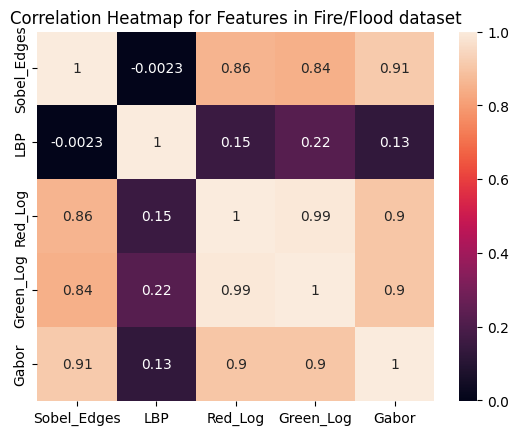

In [2]:
# Load in the dataset from the csv file
logistic_features = pd.read_csv("socal_fires_midwest_floods.csv")

#Correlation Heatmap for all features
features_only = logistic_features.drop(columns=['Label'])

heatmap = sns.heatmap(features_only.corr(), annot=True)
heatmap.set_title('Correlation Heatmap for Features in Fire/Flood dataset')

#We see from this data that several of our features have high collinearity, and thus will not be useful in our model

logistic_features.describe()

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

Logistic Regression (using features) vs. CNN (deep learning using normalized images directly)

## Logistic Regression

In [3]:
# function definitions and imports for this section
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# functions 

def calculate_correlations(data, target='Label'):
    correlations = {}
    for column in data.columns:
        if column != target and pd.api.types.is_numeric_dtype(data[column]):
            correlation = data[[column, target]].corr().iloc[0, 1]
            correlations[column] = correlation
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Label'])
    
    print(correlation_df.sort_values(by='Correlation with Label', ascending=False))
    
    return correlation_df

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    """
    return np.sqrt(mean_squared_error(actual, predicted))  


In [4]:
X = logistic_features.drop('Label', axis=1)
y = logistic_features['Label']

#Scaling and Normalizing the data so that all feature data is between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,0.141487,0.587935,0.588966,0.594512,0.119211
std,0.095990,0.100679,0.119468,0.118746,0.082151
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.069215,0.526419,0.512114,0.517353,0.060605
50%,0.115382,0.580596,0.594366,0.603294,0.100571
75%,0.196524,0.656996,0.676923,0.682394,0.160082
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#Splitting into test and train sets

X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

In [6]:
#Calculating correlation with target

columns_list = logistic_features.columns.tolist()
correlation_df = calculate_correlations(logistic_features[columns_list])

             Correlation with Label
Sobel_Edges                0.438989
Red_Log                    0.297080
Gabor                      0.251787
Green_Log                  0.228863
LBP                       -0.631108


In [16]:
#Commenting out this step because all features have < 0.8 correlation with outcome

#selected_features = correlation_df[correlation_df['Correlation with Label'].abs() < 0.1].index.tolist()

# def prepare_data(data, target='Label', is_test_set=False):

#     X = data[selected_features].fillna(0) 
    
#     if is_test_set:
#         return X   
#     else:
#         y = data[target]
#         return X, y  


#X, y = prepare_data(logistic_features, target='Label', is_test_set=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
#Computing Logistic Regression model 

model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)


In [8]:
train_rmse = rmse(y_train_pred, y_train)
test_rmse = rmse(y_valid_pred, y_valid)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {test_rmse:.2f}")

Training RMSE: 0.29
Validation RMSE: 0.30


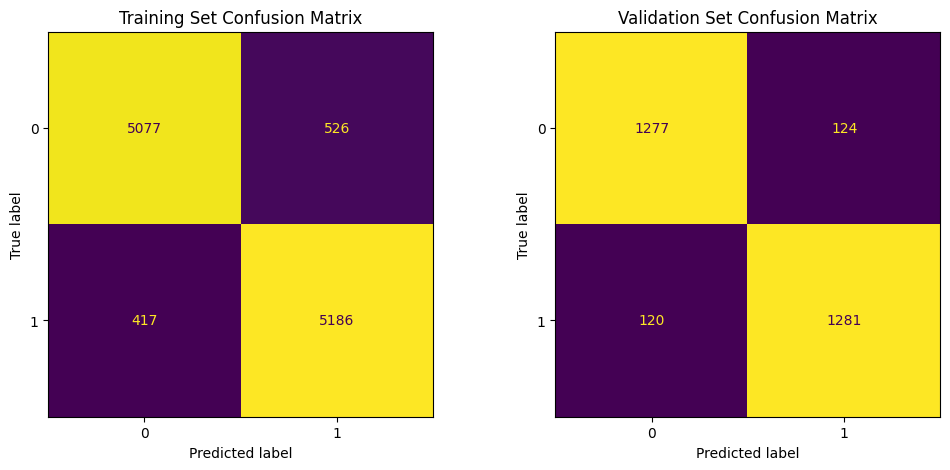

In [9]:
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=[0, 1]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Validation Set Confusion Matrix")

plt.show()


## Logistic with gradient descent and PCA

In [10]:
# necessary imports and functions for this section
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Logistic Regression
def gradient_descent_logistic(X, y, learning_rate=1, reg=0.001, iterations=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)
        dw = (1 / m) * np.dot(X.T, (y_pred - y)) + (reg / m) * weights 
        db = (1 / m) * np.sum(y_pred - y)
        weights -= learning_rate * dw
        bias -= learning_rate * db
    return weights, bias


# PCA for Dimensionality Reduction
def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca


def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_pred]

In [21]:
#Did not yield better results, not doing this

# #K-Fold Cross Validation
# def k_fold_cross_validation(X, y, learning_rate=0.1, reg=0.001, iterations=1000):
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)  
#     accuracies_valid = [] 
#     accuracies_train = []
    
#     # for each fold
#     for train_i, valid_i in kf.split(X):
#         X_train, X_valid = X[train_i], X[valid_i]
#         y_train, y_valid = y[train_i], y[valid_i]
        
#         weights, bias = gradient_descent_logistic(X_train, y_train, learning_rate, reg, iterations)
        
#         y_pred_valid = predict(X_valid, weights, bias)
#         y_pred_train = predict(X_train, weights, bias)
        
#         accuracy_valid = accuracy_score(y_valid, y_pred_valid)
#         accuracy_train = accuracy_score(y_train, y_pred_train)

#         accuracies_valid.append(accuracy_valid)
#         accuracies_train.append(accuracy_train)
    
#     avg_accuracy_valid = np.mean(accuracies_valid)
#     avg_accuracy_train = np.mean(accuracies_train)
#     return avg_accuracy_valid, avg_accuracy_train, y_pred_valid, y_pred_train

### Hyperparameter Tuning

In [11]:
# Hyperparameters to tune
learning = [0.01, 0.05, 0.1, 0.2, 1]
regs = [0.001, 0.01, 0.1, 1, 10]

top_accuracy = 0
params = {}

# Looping over hyperparameters
for rates in learning:
    for reg in regs:
        weights, bias = gradient_descent_logistic(X_train, y_train, rates, reg)
            
        y_pred_ht = predict(X_valid, weights, bias)
            
        accuracy = accuracy_score(y_valid, y_pred_ht)
                
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            params = {'learning_rate': rates, 'regularization': reg}

print(f"Tuned Parameters: {params}")
print(f"Accuracy: {top_accuracy:.4f}")

Tuned Parameters: {'learning_rate': 1, 'regularization': 0.001}
Accuracy: 0.8983


### PCA and Cumulative Variance

In [12]:
#Performing PCA on training and validation set 

if X_train.shape[1] > 4:  
    X_train_pca, X_valid_pca, pca_ratio, pca_obj = apply_pca(X_train, X_valid, n_components=4)


X_train.head()

Explained variance by PCA components: [0.76482196 0.18622139 0.03678983 0.01076145]


,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
11215,0.024674,0.734514,0.314868,0.360055,0.021478
9526,0.047097,0.426134,0.435460,0.427080,0.035631
12188,0.061352,0.657883,0.387210,0.439524,0.035015
12265,0.054510,0.626939,0.547430,0.557103,0.076350
2864,0.278187,0.540585,0.765234,0.764063,0.258680


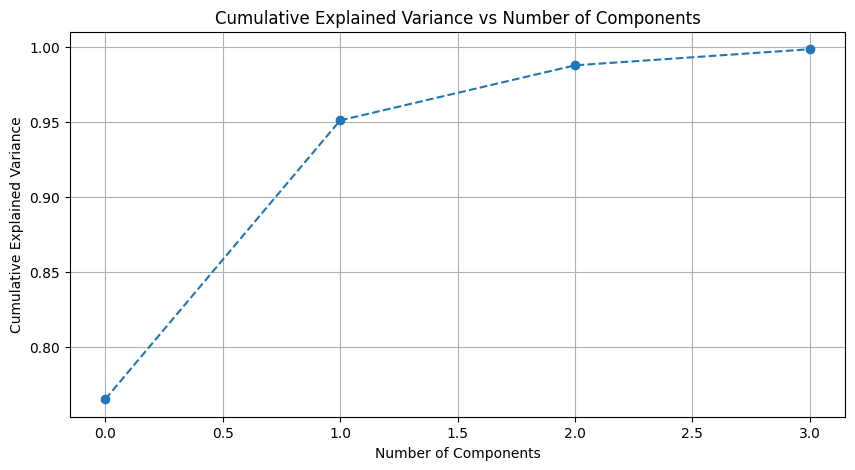

Number of components for 95% variance: 1


In [13]:
#Plotting the cumulative variance

#Calculating cumulative variance 
cumulative_explained_variance = np.cumsum(pca_ratio)

# Plot cumulative explained variance to see effect of each feature on variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 95) + 1
print(f"Number of components for 95% variance: {n_components}")

Training RMSE: 0.29
Training Accuracy score: 0.92
Validation RMSE: 0.29
Validation Accuracy score: 0.92


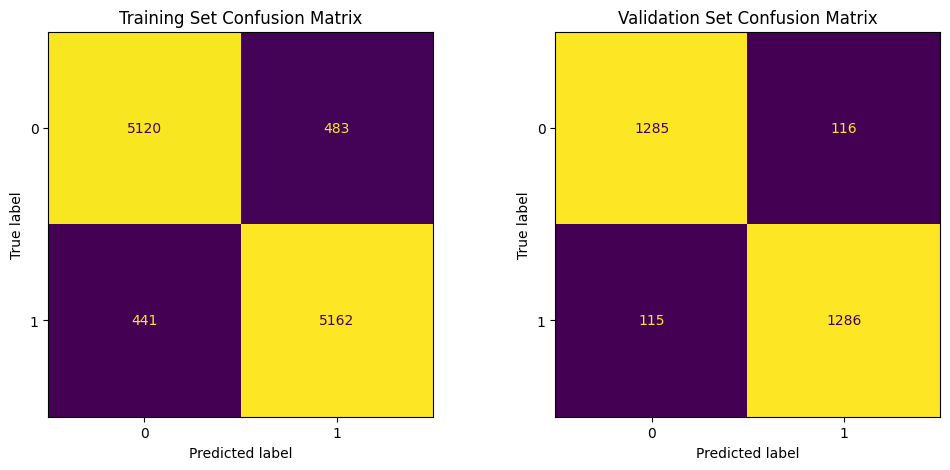

In [14]:
# Modify this line to change learning rate and iterations
weights, bias = gradient_descent_logistic(X_train_pca, y_train.values, learning_rate=1, reg=0.001, iterations=100000)
y_train_pred = predict(X_train_pca, weights, bias)
y_valid_pred = predict(X_valid_pca, weights, bias)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")

train_cm = confusion_matrix(y_train, y_train_pred)
valid_cm = confusion_matrix(y_valid, y_valid_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Validation Set Confusion Matrix")
plt.show()

## CNN

In [4]:
# necessary imports and definitions for this section
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from PIL import Image

#Used this tutorial for help: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

#Preprocess the images (resize) so they are all the same size (64 x 64)
def resize(images, size=(64, 64)):
    resized = []
    for image in images:
        image = Image.fromarray(image)
        image = image.resize(size)
        resized.append(np.array(image))
    return np.array(resized)

#Converting to Tensor (for use with PyTorch), and normalizing images
def toTensor(imageset):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    tensor = [transform(Image.fromarray(image)) for image in imageset]
    return torch.stack(tensor)

# Creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes=2): #takes in number of classes, default at 2 for fire/flood dataset
        super(ConvNeuralNet, self).__init__()
        #2 layers with a max pooling layer. 3 kernels for RGB data
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) 
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #another 2 layers with a max pooling layer
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # 2 more layers with another max pooling layer
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #dropout layer to help with overfitting
        self.drop = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(10816, 128) # linear layer
        self.softmax = nn.Softmax(dim=1) #softmax activation function
        self.fc2 = nn.Linear(128, num_classes) #linear layer that maps to the classes
    
    # Moving images through CNN    
    def forward(self, x): 
        out = self.conv_layer1(x) #first conv layer
        out = self.conv_layer2(out) #second conv layer
        out = self.max_pool1(out) #max pooling layer (dimensionality reduction)
        
        out = self.conv_layer3(out) #third conv layer
        out = self.conv_layer4(out) #fourth conv layer
        out = self.max_pool2(out) #max pooling layer (dimensionality reduction)

        out = self.drop(out) #dropout layer
                
        out = out.reshape(out.size(0), -1) # flattens to 1D before feeding to linear layers
        
        out = self.fc1(out) #first linear layer
        out = self.softmax(out) #activation function
        out = self.fc2(out) #second connected layer
        return out



### Preprocessing the images and labels

In [5]:
# loading in the raw images 

disaster_list = ["socal-fire", "midwest-flooding"]

data = {}
split = "train"

with open('config.json') as config_file:
    config = json.load(config_file)
    # data_dir = "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"
    data_dir = "../satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

# choose socal-fires from our labels list 
disaster = disaster_list[0]

#separate the labels and the images for our EDA
socal_fires_labels = data[disaster]["labels"]
socal_fires_images = data[disaster]["images"]

# choose midwest-floods from our labels list 
disaster = disaster_list[1]

#separate the labels and the images for our EDA
midwest_floods_labels = data[disaster]["labels"]
midwest_floods_images = data[disaster]["images"]


Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


In [6]:
#Setting labels for floods vs fires

socal_fires_labels_cnn = socal_fires_labels
socal_fires_labels_cnn[:] = 0

midwest_floods_labels_cnn= midwest_floods_labels
midwest_floods_labels_cnn[:] = 1

#Resizing the images

socal_fires_resized = resize(socal_fires_images)
midwest_floods_resized = resize(midwest_floods_images)

#Joining the datasets
ff_images = np.concatenate([socal_fires_resized, midwest_floods_resized])
ff_labels = np.concatenate([socal_fires_labels_cnn, midwest_floods_labels_cnn])

#Converting all images to tensors
ff_images_tensor = toTensor(ff_images)

#Converting labels to tensor
ff_labels_tensor = torch.tensor(ff_labels, dtype=torch.long)

### Creating Loader objects for PyTorch

In [7]:
#Split into validation and training sets
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(ff_images_tensor, ff_labels_tensor, test_size=0.2, random_state=42)

#Create tensor datasets to load into the loader object
train_dataset = TensorDataset(X_train_CNN, y_train_CNN)
valid_dataset = TensorDataset(X_valid_CNN, y_valid_CNN)

#Create loader objects (preserves memory by only loading the images batch by batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


### CNN Class

### Hyperparameters

In [8]:
num_classes = 2 #number of classes in our dataset
learning_rate = 0.001 #initializing initial learning rate

#setting up model using our custom class
cnn_model = ConvNeuralNet(num_classes)

# using cross entropy for the loss function
loss_func = nn.CrossEntropyLoss()

# set optimizer for CNN (stochastic gradient descent)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#set total length of training data
total_step = len(train_loader)

### Training the CNN

In [9]:
#takes ~20 mins to run!
num_epochs = 20 #number of times to run the CNN

# set device to run 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#Counters for visualization of training loss and accuracy
train_loss = []
train_accuracy = []


for epoch in range(num_epochs):
    #training mode
    cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # user loader object to load the data
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward through the CNN
        outputs = cnn_model(images) 
        loss = loss_func(outputs, labels) #calculate loss
        
        # Backpropagation, optimize parameters
        optimizer.zero_grad() #use SGD to optimize weights
        loss.backward() #check new gradient with loss function
        optimizer.step() #update weights

        running_loss += loss.item() #add all loss over this loop to running_loss

        _, predicted_train = torch.max(outputs.data, 1) # get current prediction for this epoch
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item() #compare prediction with label

    
    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader) #gives the average loss over the epoch
    train_loss.append(avg_loss)
    t_accuracy = 100 * correct_train / total_train
    train_accuracy.append(t_accuracy)
    
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}%'.format(epoch+1, num_epochs, avg_loss, t_accuracy))



Epoch [1/20], Loss: 0.6900, Accuracy: 54.497440481027056%
Epoch [2/20], Loss: 0.6890, Accuracy: 54.497440481027056%
Epoch [3/20], Loss: 0.6888, Accuracy: 54.497440481027056%
Epoch [4/20], Loss: 0.6887, Accuracy: 54.497440481027056%
Epoch [5/20], Loss: 0.6885, Accuracy: 54.497440481027056%
Epoch [6/20], Loss: 0.6883, Accuracy: 54.497440481027056%
Epoch [7/20], Loss: 0.6881, Accuracy: 54.497440481027056%


KeyboardInterrupt: 

### Testing the CNN

In [21]:
#Running training set through the optimized CNN to calculate accuracy

#do not need gradient optimization for evaluation 
with torch.no_grad():
    cnn_model.eval() #model in evaluation mode 
    correct = 0 #set initial correct prediction counter to 0 
    total = 0 #total predictions
    for images, labels in train_loader: #loop through images in the loader
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the train images: {} %'.format(100 * correct / total))

Accuracy of the network on the train images: 99.49622166246851 %


In [10]:
#Running validation set through the optimized CNN to calculate accuracy

cnn_model.eval() #model in evaluation mode


#collecting metrics from validation evaluation run as well
valid_loss = 0.0
valid_accuracy = []
correct_valid = 0
total_valid = 0

#do not need gradient optimization for validation set
with torch.no_grad(): 
    for images, labels in valid_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)

        #loss
        loss = loss_func(outputs, labels)
        valid_loss += loss.item()

        #accuracy
        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

avg_valid_loss = valid_loss / len(valid_loader)
valid_accuracy = 100 * correct_valid / total_valid
    
print(f'Validation Loss: {avg_valid_loss:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')

Validation Loss: 0.6881
Validation Accuracy: 54.37%


### CNN Loss and Accuracy Visualization

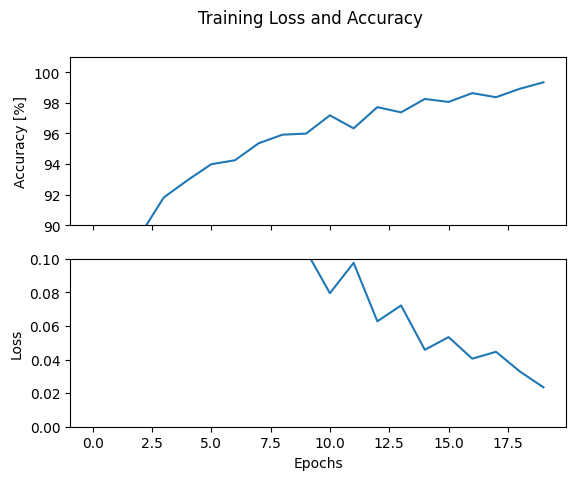

In [23]:
#Visualization of training loss and accuracy

xplot = np.arange(20)

fig1, ax1 = plt.subplots(2, 1, sharex = True)
ax1[0].plot(xplot, train_accuracy)
ax1[0].set_ylabel('Accuracy [%]')
ax1[0].set_ylim(90, 101)
ax1[1].plot(xplot, train_loss)
ax1[1].set_ylabel('Loss')
ax1[1].set_ylim(0, 0.1)

ax1[1].set_xlabel('Epochs')
fig1.suptitle('Training Loss and Accuracy')


plt.show()

## Performance Assessment

Use the model to generate predictions for the `test_images_flooding-fire.npz` images. This should be in a csv file `test_images_flooding-fire_predictions.csv` consisting of a single column with no header, with a 0 to indicate a `midwest-flooding` prediction and a 1 to indicate a `socal-fire` prediction. The prediction in row *i* should correspond to the *ith* image.

In [24]:
test_im_flood_fire_path = os.path.join(data_dir, "test_images_flooding-fire.npz")
test_im_flood_fire = load_images(test_im_flood_fire_path)

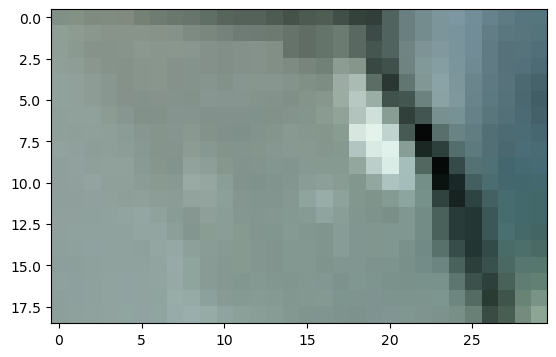

In [36]:
plt.imshow(test_im_flood_fire[0]);

## Logistic

In [37]:
test_sobel_edges = img_to_sobel(test_im_flood_fire)
test_lbp = (img_to_LBP(test_im_flood_fire))  
test_red, test_green, test_blue = image_to_RGB(test_im_flood_fire)
test_red_log = np.log(np.array(test_red))
test_green_log = np.log(np.array(test_green))
test_blue_log = np.log(np.array(test_blue))  # not used, keeping for consistency
test_gabor = img_to_gabor(test_im_flood_fire)

In [38]:
# Combine all features into df
test_features = pd.DataFrame({
    'Sobel_Edges': test_sobel_edges,
    "LBP": test_lbp,
    'Red_Log': test_red_log,
    'Green_Log': test_green_log,
    'Gabor': test_gabor
})

In [39]:
test_predictions = model.predict(test_features)
output_path = "logistic_test_images_flooding-fire_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

## Gradient Descent Logistic

In [40]:
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_pred]

pca_test = pca_obj.transform(test_features)

test_predictions = predict(pca_test, weights, bias)

output_path = "gradient_logistic_test_images_flooding-fire_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to gradient_logistic_test_images_flooding-fire_predictions.csv


/tmp/ipykernel_1539028/896558915.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


## CNN

In [ ]:
# Define a loader for the test dataset
test_images = resize(test_im_flood_fire)
test_features = toTensor(test_images)

test_dataset = TensorDataset(test_features)

test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

cnn_model.eval() #model in test mode

test_predictions = []

#do not need gradient optimization 
with torch.no_grad(): 
    for images in test_loader: 
        images = images[0].to(device)
        outputs = cnn_model(images)

        _, predicted = torch.max(outputs.data, 1)

        test_predictions.append(predicted.cpu().numpy())

output_path = "cnn_test_images_flooding-fire_predictions_v3.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to cnn_test_images_flooding-fire_predictions.csv
